In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # Import L2 regularizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
import numpy as np
import random

# Function to preprocess spectrograms
def preprocess_spectrogram(spectrogram, target_size):
    # Normalize
    spectrogram = spectrogram / np.max(spectrogram)
    # Resize to match MobileNet input
    spectrogram = tf.image.resize(spectrogram, target_size)
    # Convert to 3 channels (stack the same data for all channels)
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)
    return spectrogram.numpy()

# Data augmentation for spectrograms
def augment_spectrogram(spectrogram):
    # Time shifting
    shift = random.randint(-10, 10)
    spectrogram = np.roll(spectrogram, shift, axis=1)

    # Frequency masking
    freq_mask = random.randint(0, 10)
    spectrogram[:, freq_mask:freq_mask + 10, :] = 0

    # Time masking
    time_mask = random.randint(0, 10)
    spectrogram[time_mask:time_mask + 10, :, :] = 0

    return spectrogram

# Create a model with MobileNetV2 as the base and L2 regularization
def create_model(input_shape):
    # Load MobileNetV2 without the top layers
    weights_path = './models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False
    #base_model.trainable = True
    for layer in base_model.layers[-3:0]:  # Freeze the first 100 layers
        layer.trainable = True

    # Add custom layers with L2 regularization
    model = Sequential([
        base_model,
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # L2 regularization
        BatchNormalization(),
        ReLU(),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # L2 regularization
    ])
    return model
# Load and preprocess spectrogram dataset
def load_data(image_folder, txt_folder, target_size):
    image_paths = []
    labels = []

    # Read labels and corresponding spectrogram paths
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as file:
                label = int(file.read().strip())
                image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming spectrograms are in .jpg format
                image_path = os.path.join(image_folder, image_name)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    # Preprocess spectrograms
    X = []
    y = []
    for img_path, label in zip(image_paths, labels):
        spectrogram = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
        spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
        spectrogram = preprocess_spectrogram(spectrogram, target_size)
        spectrogram = augment_spectrogram(spectrogram)  # Apply augmentation
        X.append(spectrogram)
        y.append(label)

    return np.array(X), np.array(y)


# Input shape for spectrograms
input_shape = (128, 128, 3)

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Display model summary
model.summary()



# Paths to dataset
image_folder = 'Dataset_Model/Final_dataset/56k_train_images'  # Replace with your training spectrogram images path
txt_folder = 'Dataset_Model/Final_dataset/56k_train_labels'  # Replace with your training labels path

# Load data
X, y = load_data(image_folder, txt_folder, (128, 128))

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train, X_val, y_train, y_val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,995,585 (15.24 MB)

 Trainable params: 1,737,345 (6.63 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.58406115 0.58406115 0.58406115]
   [0.59497815 0.59497815 0.59497815]
   [0.5862445  0.5862445  0.5862445 ]
   ...
   [0.61353713 0.61353713 0.61353713]
   [0.6069869  0.6069869  0.6069869 ]
   [0.58078605 0.58078605 0.58078605]]

  [[0.58842796 0.58842796 0.58842796]
   [0.5

In [2]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")


X_train shape: (51200, 128, 128, 3)
X_val shape: (12800, 128, 128, 3)
y_train shape: (51200,)
y_val shape: (12800,)
Training labels distribution: [12800 38400]
Validation labels distribution: [3200 9600]


Epoch 1/100


/opt/homebrew/Cellar/jupyterlab/4.3.1/libexec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


800/800 ━━━━━━━━━━━━━━━━━━━━ 146s 180ms/step - accuracy: 0.8039 - loss: 4.9658 - precision: 0.8296 - recall: 0.9305 - val_accuracy: 0.8966 - val_loss: 4.0957 - val_precision: 0.8949 - val_recall: 0.9769 - learning_rate: 1.0000e-05
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 149s 186ms/step - accuracy: 0.8882 - loss: 3.9179 - precision: 0.8955 - recall: 0.9632 - val_accuracy: 0.9057 - val_loss: 3.3510 - val_precision: 0.9056 - val_recall: 0.9760 - learning_rate: 1.0000e-05
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 152s 190ms/step - accuracy: 0.8998 - loss: 3.2144 - precision: 0.9043 - recall: 0.9690 - val_accuracy: 0.9080 - val_loss: 2.7931 - val_precision: 0.9108 - val_recall: 0.9727 - learning_rate: 1.0000e-05
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 153s 191ms/step - accuracy: 0.9051 - loss: 2.6864 - precision: 0.9090 - recall: 0.9705 - val_accuracy: 0.9098 - val_loss: 2.3654 - val_precision: 0.9109 - val_recall: 0.9750 - learning_rate: 1.0000e-05
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━

<Figure size 800x600 with 0 Axes>

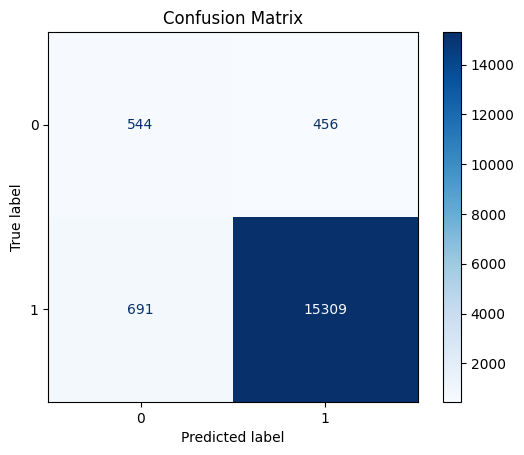

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create data generators
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

# Callbacks for training
callbacks = [
    ModelCheckpoint('best_model_mobilenetv1_l2_Nov22.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

# Save the trained model
model.save('final_model_mobilenetv2_l2_Nov22.keras')

# Load test data
test_image_folder = 'Dataset_Model/Final_dataset/17k_test_images'  # Replace with your test spectrogram images path
test_txt_folder = 'Dataset_Model/Final_dataset/17k_test_labels'  # Replace with your test labels path
X_test, y_test = load_data(test_image_folder, test_txt_folder, (128, 128))

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()
